Se uso una base de datos de imagenes de rayos X para detectar si el paciente tiene neumonia o no.

In [8]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:

# Directorios de las imágenes de entrenamiento y prueba en Google Drive
train_normal_dir = '/content/drive/MyDrive/IMAGES XRAY/TRAIN_NORMAL'
train_abnormal_dir = '/content/drive/MyDrive/IMAGES XRAY/TRAIN_PNEUMONIA'
test_normal_dir = '/content/drive/MyDrive/IMAGES XRAY/TEST_NORMAL'
test_abnormal_dir = '/content/drive/MyDrive/IMAGES XRAY/TEST_PNEUMONIA'

# Parámetros
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

def load_images_from_directory(directory, label, img_size=IMG_SIZE):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

# Cargar imágenes de entrenamiento
train_normal_images, train_normal_labels = load_images_from_directory(train_normal_dir, 0)
train_abnormal_images, train_abnormal_labels = load_images_from_directory(train_abnormal_dir, 1)

# Cargar imágenes de prueba
test_normal_images, test_normal_labels = load_images_from_directory(test_normal_dir, 0)
test_abnormal_images, test_abnormal_labels = load_images_from_directory(test_abnormal_dir, 1)

# Unir los conjuntos de entrenamiento y prueba
x_train = np.concatenate((train_normal_images, train_abnormal_images), axis=0)
y_train = np.concatenate((train_normal_labels, train_abnormal_labels), axis=0)
x_test = np.concatenate((test_normal_images, test_abnormal_images), axis=0)
y_test = np.concatenate((test_normal_labels, test_abnormal_labels), axis=0)

# Mezclar los datos
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(x_test.shape[0])
np.random.shuffle(test_indices)
x_test = x_test[test_indices]
y_test = y_test[test_indices]

# Normalizar las imágenes
x_train = x_train / 255.0
x_test = x_test / 255.0

In [10]:
# Generadores de datos con aumento de datos
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Creación del modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=20,
    validation_data=(x_test, y_test)
)

# Evaluación del modelo
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Epoch 1/20
12/12 [==============================] - 30s 2s/step - loss: 0.6726 - accuracy: 0.5452 - val_loss: 0.6835 - val_accuracy: 0.4359
Epoch 2/20
12/12 [==============================] - 26s 2s/step - loss: 0.6826 - accuracy: 0.5729 - val_loss: 0.6986 - val_accuracy: 0.3718
Epoch 3/20
12/12 [==============================] - 27s 2s/step - loss: 0.6350 - accuracy: 0.6695 - val_loss: 0.6734 - val_accuracy: 0.4444
Epoch 4/20
12/12 [==============================] - 24s 2s/step - loss: 0.5967 - accuracy: 0.7232 - val_loss: 0.5880 - val_accuracy: 0.7265
Epoch 5/20
12/12 [==============================] - 27s 2s/step - loss: 0.5827 - accuracy: 0.6953 - val_loss: 0.6553 - val_accuracy: 0.5299
Epoch 6/20
12/12 [==============================] - 24s 2s/step - loss: 0.5037 - accuracy: 0.7994 - val_loss: 0.5071 - val_accuracy: 0.8248
Epoch 7/20
12/12 [==============================] - 24s 2s/step - loss: 0.4692 - accuracy: 0.8249 - val_loss: 0.6102 - val_accuracy: 0.6368
Epoch 8/20
12/12 [==

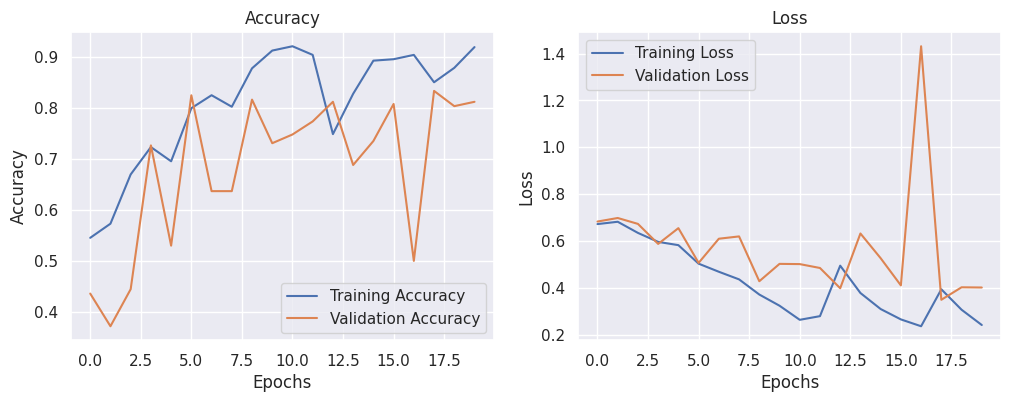

In [11]:
# Graficar Accuracy y Pérdida
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)